<a href="https://colab.research.google.com/github/shielamms/Tensorflow-Notebooks/blob/main/Deep_Neural_Network_Training_on_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf

In [11]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Synthetic Data

### Plotting function

In [12]:
def plot_series(time, series, format='-', start=0, end=None, figsize=(10,6)):
  plt.figure(figsize=figsize)

  if isinstance(series, tuple):
    for s in series:
      plt.plot(time[start:end], s[start:end], format)
  else:
    plt.plot(time[start:end], series[start:end], format)

  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)
  plt.show()

### Time series properties

In [13]:
def trend(time, slope=0):
  """
  Generate synthetic time series data following a straight line of a given slope
  """

  return slope * time


def seasonality(time, period, amplitude=1, phase=0):
  """
  Repeat an arbitrary pattern at each period
  """

  def seasonal_pattern(season_time):
    """
    Generate an arbitrary pattern simulating a seasonal pattern
    """
    pattern = np.where(season_time < 0.4,
                      np.cos(season_time * 2 * np.pi),
                      1 / np.exp(3 * season_time))
    return pattern
  
  season_time = ((time + phase) % period) / period
  data_pattern = amplitude * seasonal_pattern(season_time)
  return data_pattern


def noise(time, noise_level=1, seed=None):
  """
  Generate normally distributed noisy data
  """

  rnd = np.random.RandomState(seed)
  noise = rnd.randn(len(time)) * noise_level
  return noise


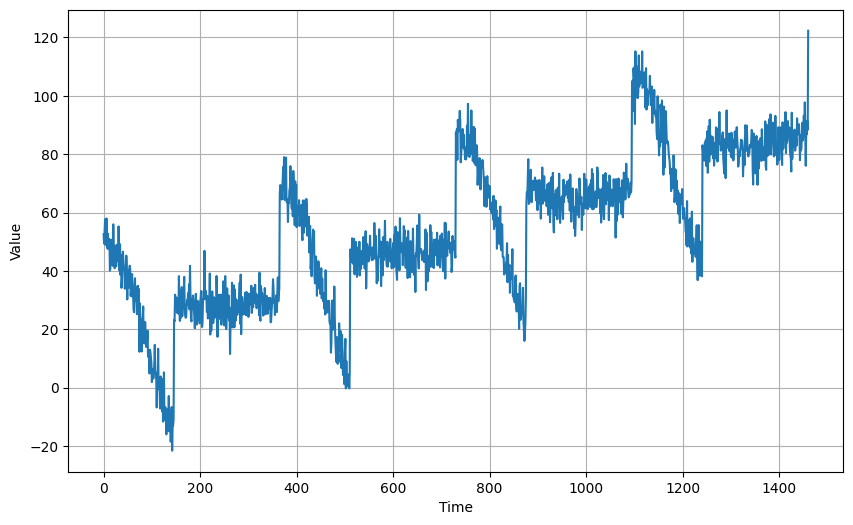

In [14]:
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = (
    baseline
    + trend(time, slope)
    + seasonality(time, period=365, amplitude=amplitude)
)

series += noise(time, noise_level, seed=42)

plot_series(time, series)

### Train and validation split

In [15]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

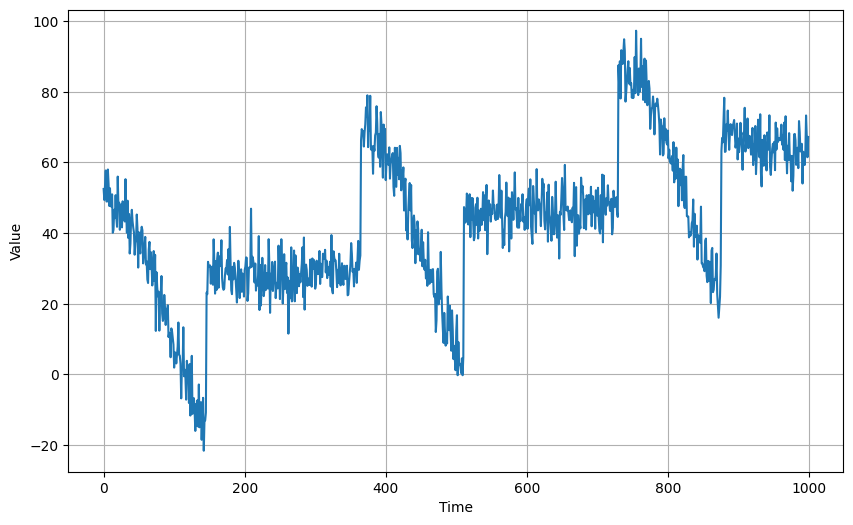

In [16]:
plot_series(time_train, x_train)

## Windowed Data Prep

### Sample

In [17]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)

# for data in dataset:
#   print([val.numpy() for val in data])

# Flatten dataset into a tensor
dataset = dataset.flat_map(lambda window: window.batch(5))

# Split dataset to features and labels, then shuffle the time windows
dataset = dataset.map(lambda x: (x[:-1], x[-1])).shuffle(buffer_size=10)

# Create batches of windows
dataset = dataset.batch(2).prefetch(1)

for x,y in dataset:
  print(f'X = {x}')
  print(f'y = {y}')
  print()

X = [[2 3 4 5]
 [4 5 6 7]]
y = [6 8]

X = [[5 6 7 8]
 [1 2 3 4]]
y = [9 5]

X = [[3 4 5 6]
 [0 1 2 3]]
y = [7 4]



### On the dataset

In [18]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [20]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [21]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


# Single Layer Neural Network

## Build the model

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[window_size])
])

print("Layer weights: \n {} \n".format(model.get_weights()))


Layer weights: 
 [array([[-0.47537702],
       [-0.24808991],
       [-0.04502255],
       [-0.3630554 ],
       [ 0.20866543],
       [-0.1451349 ],
       [ 0.08424634],
       [ 0.49976057],
       [-0.16733545],
       [ 0.3768834 ],
       [ 0.4277212 ],
       [-0.5207112 ],
       [-0.22794941],
       [ 0.246391  ],
       [-0.29242212],
       [ 0.39603853],
       [-0.36603126],
       [-0.4518665 ],
       [-0.11338255],
       [ 0.3255604 ]], dtype=float32), array([0.], dtype=float32)] 



In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,
                                                momentum=0.9))

## Train the model

In [25]:
EPOCHS = 100

history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 1480.6031
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 210.2011
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 142.0654
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 127.9793
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 118.9071
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 115.7274
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 104.4484
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 103.5422
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 96.0601
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 90.5414
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 86.9716
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 84.0743
Epoch 13/100
31/

## Prediction

In [26]:
print(f'shape of series[0:20]: {series[0:20].shape}')

shape of series[0:20]: (20,)


In [27]:
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

shape of series[0:20][np.newaxis]: (1, 20)


In [28]:
print(f'model prediction: {model.predict(np.expand_dims(series[0:20], axis=0))}')

1/1 [==============================] - 0s 92ms/step
model prediction: [[42.87394]]


In [29]:
forecast = []

for time in range(len(series) - window_size):
  prediction = model.predict(np.expand_dims(series[time:time+window_size],
                                            axis=0))
  forecast.append(prediction)

# Slice to the first prediction in the validation set
# (the predictors are the 20 units before the first unit of the validation set)
forecast = forecast[split_time-window_size:]

print(f'Length of forecast: {len(forecast)}')
print(f'Shape of validation set: {x_valid.shape}')


1/1 [==============================] - 0s 97ms/step
Length of forecast: 461
Shape of validation set: (461,)


In [30]:
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


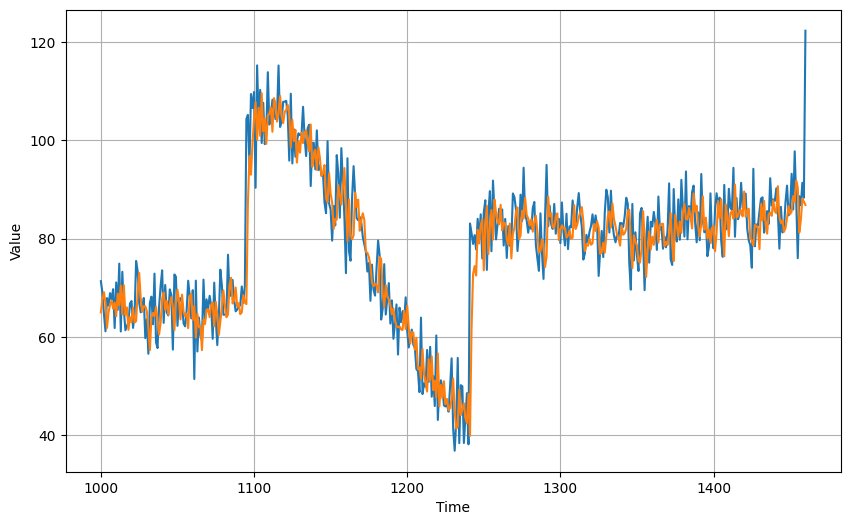

In [31]:
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
plot_series(time_valid, (x_valid, results))

In [32]:
print(f'Mean squared error: {tf.keras.metrics.mean_squared_error(x_valid, results).numpy()}')
print(f'Mean absolute error: {tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()}')

Mean squared error: 48.123313903808594
Mean absolute error: 5.1303887367248535


# Deep Neural Network

## Build the model

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [34]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20)
# )

optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

model.compile(loss='mse', optimizer=optimizer)

In [35]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 364.7104
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 94.9928
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 70.9531
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 70.7867
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 62.6642
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 60.0363
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 60.0460
Epoch 8/100
31/31 [==============================] - 1s 5ms/step - loss: 58.2133
Epoch 9/100
31/31 [==============================] - 1s 6ms/step - loss: 59.7045
Epoch 10/100
31/31 [==============================] - 1s 6ms/step - loss: 57.6309
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 53.6355
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 55.1198
Epoch 13/100
31/31 [====

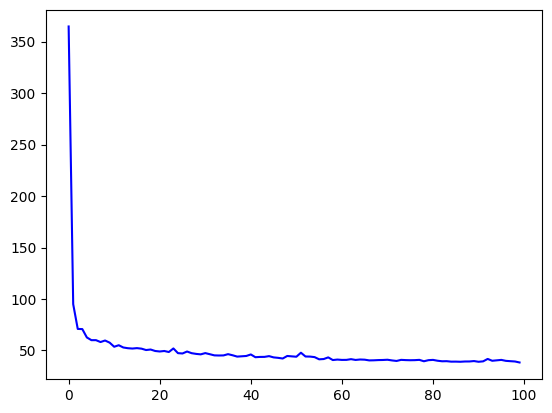

In [36]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

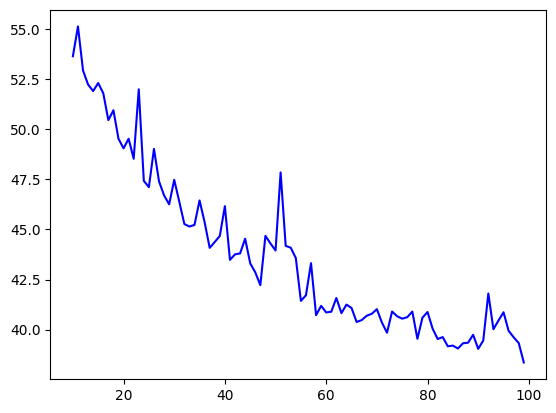

In [37]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

## Prediction

In [38]:
forecast = []

for time in range(len(series) - window_size):
  prediction = model.predict(np.expand_dims(series[time:time+window_size],
                                            axis=0))
  forecast.append(prediction)

# Slice to the first prediction in the validation set
# (the predictors are the 20 units before the first unit of the validation set)
forecast = forecast[split_time-window_size:]

print(f'Length of forecast: {len(forecast)}')
print(f'Shape of validation set: {x_valid.shape}')

1/1 [==============================] - 0s 23ms/step
Length of forecast: 461
Shape of validation set: (461,)


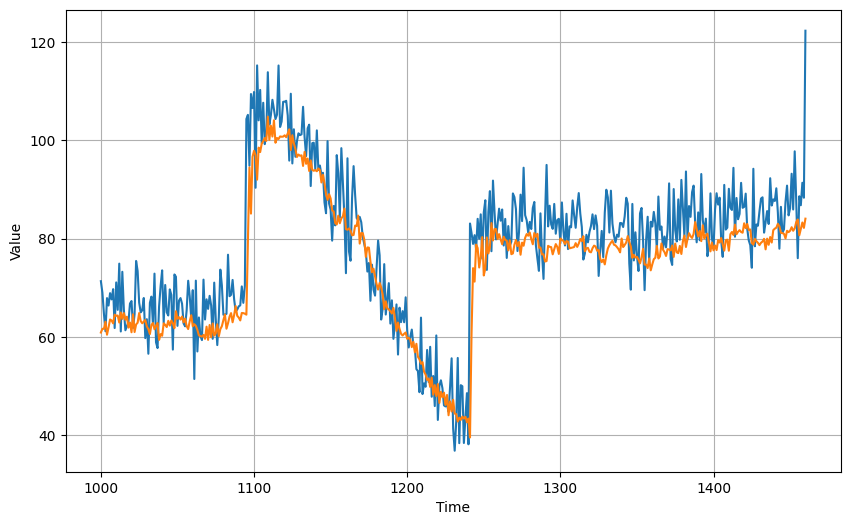

In [39]:
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
plot_series(time_valid, (x_valid, results))

# Training with Recurrent Layers

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 1e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])


In [41]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
31/31 [==============================] - 3s 13ms/step - loss: 70.9556 - mae: 71.4546
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 16.4991 - mae: 16.9936
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 13.9714 - mae: 14.4644
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 13.2471 - mae: 13.7367
Epoch 5/100
31/31 [==============================] - 1s 14ms/step - loss: 12.8661 - mae: 13.3587
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 12.1972 - mae: 12.6867
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 11.5059 - mae: 11.9942
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 10.6304 - mae: 11.1207
Epoch 9/100
31/31 [==============================] - 0s 12ms/step - loss: 10.0292 - mae: 10.5169
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 9.5245 - mae: 10.0146
Epoch 11/100
31/31 [==========

1/1 [==============================] - 0s 26ms/step


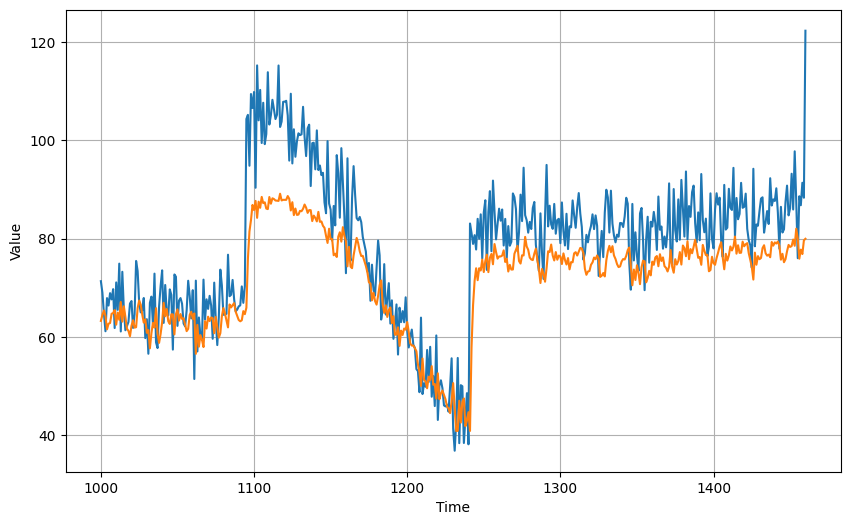

In [42]:
forecast = []

forecast_series = series[split_time - window_size:]

for time in range(len(forecast_series) - window_size):
  prediction = model.predict(np.expand_dims(forecast_series[time:time+window_size],
                                            axis=0))
  forecast.append(prediction)

results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [43]:
# Alternative prediction function
def model_forecast(model, series, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

15/15 [==============================] - 0s 9ms/step


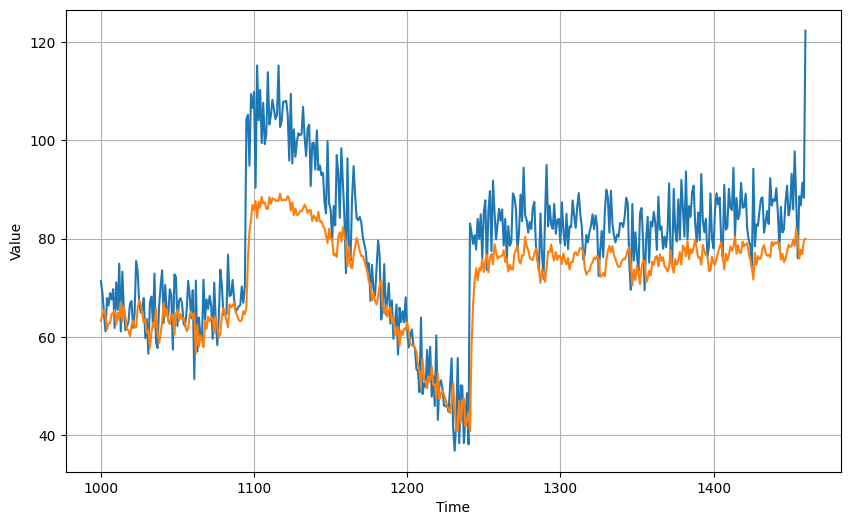

In [44]:
forecast_series = series[split_time - window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [45]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

103.75185
7.916435


# Training with LSTMs

In [46]:
tf.keras.backend.clear_session()

In [46]:
model = tf.keras.Sequential({
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
})

In [47]:
learning_rate = 2e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [48]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
31/31 [==============================] - 3s 13ms/step - loss: 5.2076 - mae: 5.6844
Epoch 2/100
31/31 [==============================] - 1s 12ms/step - loss: 5.1493 - mae: 5.6284
Epoch 3/100
31/31 [==============================] - 1s 13ms/step - loss: 5.6355 - mae: 6.1138
Epoch 4/100
31/31 [==============================] - 1s 12ms/step - loss: 5.1120 - mae: 5.5914
Epoch 5/100
31/31 [==============================] - 1s 13ms/step - loss: 5.1041 - mae: 5.5865
Epoch 6/100
31/31 [==============================] - 1s 12ms/step - loss: 5.3501 - mae: 5.8274
Epoch 7/100
31/31 [==============================] - 1s 13ms/step - loss: 5.2315 - mae: 5.7047
Epoch 8/100
31/31 [==============================] - 1s 13ms/step - loss: 5.5217 - mae: 5.9982
Epoch 9/100
31/31 [==============================] - 1s 12ms/step - loss: 5.6938 - mae: 6.1744
Epoch 10/100
31/31 [==============================] - 1s 13ms/step - loss: 5.7737 - mae: 6.2586
Epoch 11/100
31/31 [=============================

15/15 [==============================] - 2s 30ms/step


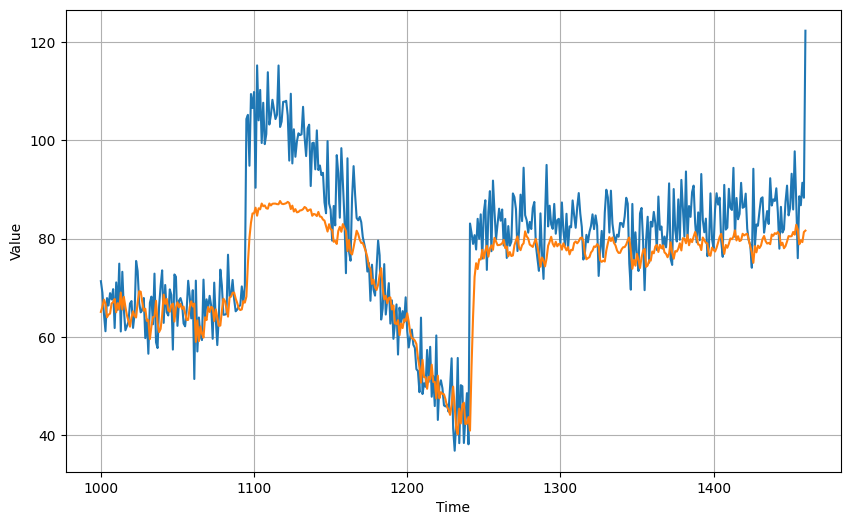

In [49]:
forecast_series = series[split_time - window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

In [50]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

86.87873
6.8945417
